1) Cargar datos y mapeos

In [1]:
import sys
print(sys.executable)

C:\Users\raulc\anaconda3\envs\futgnn\python.exe


In [1]:
from pathlib import Path

def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for cand in [p, *p.parents]:
        if (cand / "data").exists() and (cand / "src").exists():
            return cand
    return p  # fallback

ROOT = find_repo_root()
print("CWD      :", Path.cwd())
print("REPO ROOT:", ROOT)

RAW     = ROOT / "data" / "raw" / "Real Madrid 1-2 Valencia-LaLiga-2025-04-05.csv"
PROC_G  = ROOT / "data" / "processed" / "passes_GLOBAL.gpickle"
PROC_PT = ROOT / "data" / "processed" / "passes_GLOBAL.pt"

print("RAW exists?     ", RAW.exists())
print("PROC_G exists?  ", PROC_G.exists())
print("PROC_PT exists? ", PROC_PT.exists())

CWD      : E:\proyectos\MaestriaIAA\tt\FutGNN\notebooks
REPO ROOT: E:\proyectos\MaestriaIAA\tt\FutGNN
RAW exists?      True
PROC_G exists?   True
PROC_PT exists?  True


In [2]:
import pandas as pd, torch, pickle, networkx as nx

# CSV original
events = pd.read_csv(RAW, encoding="utf-8-sig", on_bad_lines="skip")

# Grafo NetworkX (uso robusto)
try:
    from networkx.readwrite.gpickle import read_gpickle
    G = read_gpickle(PROC_G)
except Exception:
    with open(PROC_G, "rb") as f:
        G = pickle.load(f)

# Objeto PyG
data = torch.load(PROC_PT)

len(G), G.number_of_edges(), data

C:\Users\raulc\AppData\Local\Temp\ipykernel_16888\197918016.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(PROC_PT)


(32,
 331,
 Data(x=[32, 2], edge_index=[2, 331], edge_attr=[331, 2], node_ids=[32]))

2) Resúmenes rápidos (nodos, aristas, pesos, éxito)
   

In [3]:
#%pip install matplotlib

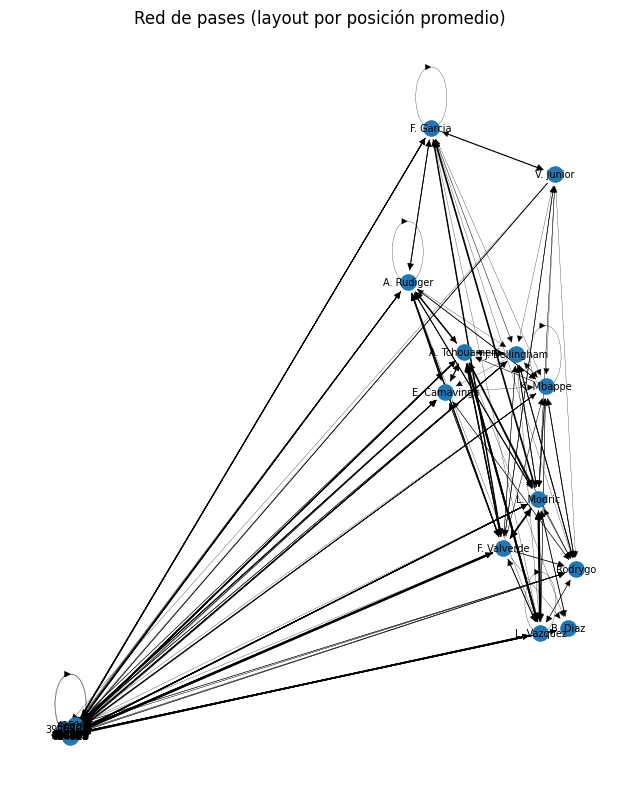

In [4]:
# CELDA ÚNICA: carga grafo, crea mapeos (name_map/pos_xy) y dibuja
from pathlib import Path
import pandas as pd, numpy as np, pickle, networkx as nx
import matplotlib.pyplot as plt

# --- localizar raíz del repo y rutas ---
def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for cand in [p, *p.parents]:
        if (cand / "data").exists() and (cand / "src").exists():
            return cand
    return p

ROOT    = find_repo_root()
RAW     = ROOT / "data" / "raw" / "Atletico Madrid 1-0 Real Madrid-Champions League-2025-04-07.csv"
PROC_G  = ROOT / "data" / "processed" / "passes_GLOBAL.gpickle"

# --- cargar eventos y grafo ---
events = pd.read_csv(RAW, encoding="utf-8-sig", on_bad_lines="skip")
try:
    from networkx.readwrite.gpickle import read_gpickle
    G = read_gpickle(PROC_G)
except Exception:
    with open(PROC_G, "rb") as f:
        G = pickle.load(f)

# --- mapeos jugador->nombre/dorsal/equipo (si existen columnas) ---
def map_from(df, key, value):
    if key in df and value in df:
        return (df[[key, value]].dropna().drop_duplicates(key).set_index(key)[value].to_dict())
    return {}

name_map  = map_from(events, "playerId", "shortName")
shirt_map = map_from(events, "playerId", "shirtNo")
team_map  = map_from(events, "playerId", "teamId")

# --- posición media por jugador usando inicios de pase ---
if all(c in events.columns for c in ["playerId","x","y","type"]):
    pos_df = events[events["type"].astype(str).str.lower().eq("pass")][["playerId","x","y"]].dropna()
    pos_xy = pos_df.groupby("playerId")[["x","y"]].mean().to_dict("index")
else:
    pos_xy = {}

# --- layout: usa posición media y completa faltantes con spring ---
pos, missing = {}, []
for n in G.nodes():
    xy = pos_xy.get(n)
    if xy is not None:
        pos[n] = (xy["x"], xy["y"])
    else:
        missing.append(n)
if missing:
    spring_pos = nx.spring_layout(G.subgraph(missing), seed=1)
    for n in missing:
        pos[n] = spring_pos[n]

# --- dibujar ---
plt.figure(figsize=(8, 10))
weights = [min(4, 0.2 * d.get("weight", 1)) for *_, d in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=weights, arrows=True, arrowsize=10)
nx.draw_networkx_nodes(G, pos, node_size=120)
labels = {n: name_map.get(n, str(n)) for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=7)
plt.axis("off")
plt.title("Red de pases (layout por posición promedio)")
plt.show()

3) Métricas de centralidad (baseline)

In [5]:
# PUNTO 3 — MÉTRICAS DE CENTRALIDAD (CELDA AUTOSUFICIENTE)
from pathlib import Path
import pandas as pd, numpy as np, networkx as nx, pickle
from IPython.display import display

# --- asegura que exista G y ROOT ---
if 'G' not in globals():
    ROOT = Path.cwd()
    for cand in [ROOT, *ROOT.parents]:
        if (cand / "data" / "processed" / "passes_GLOBAL.gpickle").exists():
            ROOT = cand
            break
    try:
        from networkx.readwrite.gpickle import read_gpickle
        G = read_gpickle(ROOT / "data" / "processed" / "passes_GLOBAL.gpickle")
    except Exception:
        with open(ROOT / "data" / "processed" / "passes_GLOBAL.gpickle", "rb") as f:
            G = pickle.load(f)
else:
    # intenta deducir ROOT desde donde estés trabajando
    ROOT = Path.cwd()
    for cand in [ROOT, *ROOT.parents]:
        if (cand / "data").exists() and (cand / "src").exists():
            ROOT = cand
            break

# --- nodes_df mínimo si no existe ---
if 'nodes_df' not in globals():
    nodes_df = pd.DataFrame({'player_id': list(G.nodes())})

# --- grados (out/in) ---
deg_out = dict(G.out_degree())
deg_in  = dict(G.in_degree())

# --- strengths (suma de pesos) ---
out_strength = {n: 0.0 for n in G.nodes()}
in_strength  = {n: 0.0 for n in G.nodes()}
for u, v, d in G.edges(data=True):
    w = float(d.get('weight', 1))
    out_strength[u] += w
    in_strength[v]  += w

# --- betweenness (no ponderado) ---
bet_unw = nx.betweenness_centrality(G, normalized=True)

# --- betweenness "ponderado": tratamos peso como conductancia => longitud = 1/weight ---
H = G.copy()
for u, v, d in H.edges(data=True):
    w = float(d.get('weight', 1))
    d['length'] = 1.0 / max(w, 1e-9)
bet_w = nx.betweenness_centrality(H, normalized=True, weight='length')

# --- PageRank ponderado por 'weight' ---
try:
    pr_w = nx.pagerank(G, alpha=0.85, weight='weight', max_iter=100)
except Exception:
    pr_w = {n: np.nan for n in G.nodes()}

# --- combina en nodes_df ---
nodes_df = nodes_df.set_index('player_id')
nodes_df['deg_out']       = nodes_df.index.map(deg_out.get)
nodes_df['deg_in']        = nodes_df.index.map(deg_in.get)
nodes_df['str_out']       = nodes_df.index.map(out_strength.get)
nodes_df['str_in']        = nodes_df.index.map(in_strength.get)
nodes_df['betweenness']   = nodes_df.index.map(bet_unw.get)
nodes_df['betweenness_w'] = nodes_df.index.map(bet_w.get)
nodes_df['pagerank_w']    = nodes_df.index.map(pr_w.get)
nodes_df = nodes_df.reset_index()

# --- helpers para mostrar top-k ---
def top(df, col, k=15):
    cols = [c for c in ['name','player_id','team','shirt',col] if c in df.columns]
    return df.sort_values(col, ascending=False)[cols].head(k)

print("Top betweenness (no ponderado):")
display(top(nodes_df, 'betweenness'))

print("Top betweenness (ponderado por 1/weight):")
display(top(nodes_df, 'betweenness_w'))

print("Top PageRank (ponderado):")
display(top(nodes_df, 'pagerank_w'))

print("Top out-strength (suma de pesos enviados):")
display(top(nodes_df, 'str_out'))

# (opcional) guarda tabla completa de centralidades
out_csv = ROOT / "data" / "processed" / "centrality_GLOBAL.csv"
nodes_df.to_csv(out_csv, index=False)
print("Centralidades guardadas en:", out_csv)

Top betweenness (no ponderado):


,player_id,betweenness
1,456787,0.116097
14,20874,0.073372
13,344644,0.064657
21,353423,0.057175
12,422957,0.053588
11,422656,0.052559
10,431507,0.047582
22,347862,0.046162
27,369109,0.042919
16,379868,0.038845


Top betweenness (ponderado por 1/weight):


,player_id,betweenness_w
10,431507,0.187724
13,344644,0.181362
14,20874,0.174373
21,353423,0.162186
1,456787,0.136559
11,422656,0.086022
8,408732,0.084946
9,322095,0.070430
27,369109,0.065054
12,422957,0.064695


Top PageRank (ponderado):


,player_id,pagerank_w
1,456787,0.110059
8,408732,0.079538
17,322246,0.075198
10,431507,0.071354
9,322095,0.063252
11,422656,0.061373
0,297546,0.048665
4,362103,0.046326
3,425591,0.045339
14,20874,0.027235


Top out-strength (suma de pesos enviados):


,player_id,str_out
13,344644,64.0
14,20874,56.0
21,353423,52.0
7,144511,45.0
5,104010,41.0
1,456787,41.0
12,422957,33.0
10,431507,33.0
17,322246,30.0
16,379868,28.0


Centralidades guardadas en: E:\proyectos\MaestriaIAA\tt\FutGNN\data\processed\centrality_GLOBAL.csv


4) Visualización rápida de la red (layout por posición promedio)

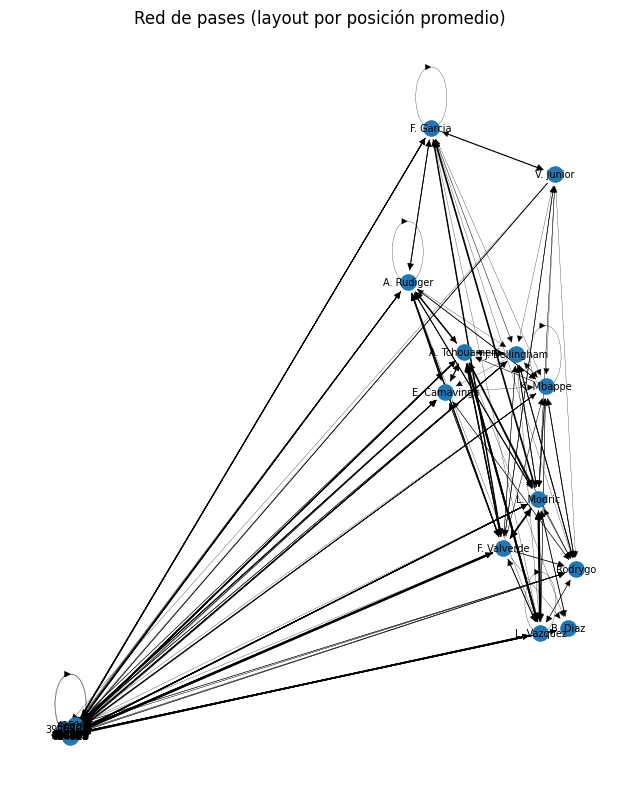

In [6]:
# 4A) Dibujo de la red (layout por posición promedio; completa faltantes con spring)
from pathlib import Path
import pandas as pd, numpy as np, pickle, networkx as nx
import matplotlib.pyplot as plt

def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for cand in [p, *p.parents]:
        if (cand / "data").exists() and (cand / "src").exists():
            return cand
    return p

ROOT    = find_repo_root()
RAW     = ROOT / "data" / "raw" / "Atletico Madrid 1-0 Real Madrid-Champions League-2025-04-07.csv"
PROC_G  = ROOT / "data" / "processed" / "passes_GLOBAL.gpickle"

# Carga G y eventos si faltan
if 'G' not in globals():
    try:
        from networkx.readwrite.gpickle import read_gpickle
        G = read_gpickle(PROC_G)
    except Exception:
        with open(PROC_G, "rb") as f:
            G = pickle.load(f)

if 'events' not in globals():
    events = pd.read_csv(RAW, encoding="utf-8-sig", on_bad_lines="skip")

# Mapeos mínimos si faltan
def map_from(df, key, value):
    if key in df and value in df:
        return (df[[key, value]].dropna().drop_duplicates(key).set_index(key)[value].to_dict())
    return {}
if 'name_map' not in globals():
    name_map = map_from(events, "playerId", "shortName")

# Posición promedio por jugador si falta
if 'pos_xy' not in globals():
    if all(c in events.columns for c in ["playerId","x","y","type"]):
        pos_df = events[events["type"].astype(str).str.lower().eq("pass")][["playerId","x","y"]].dropna()
        pos_xy = pos_df.groupby("playerId")[["x","y"]].mean().to_dict("index")
    else:
        pos_xy = {}

# Layout
pos, missing = {}, []
for n in G.nodes():
    xy = pos_xy.get(n)
    if xy is not None:
        pos[n] = (float(xy["x"]), float(xy["y"]))
    else:
        missing.append(n)
if missing:
    spring_pos = nx.spring_layout(G.subgraph(missing), seed=1)
    for n in missing:
        pos[n] = spring_pos[n]

plt.figure(figsize=(8, 10))
weights = [min(4, 0.2 * d.get("weight", 1)) for *_, d in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=weights, arrows=True, arrowsize=10)
nx.draw_networkx_nodes(G, pos, node_size=120)
labels = {n: name_map.get(n, str(n)) for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=7)
plt.axis("off")
plt.title("Red de pases (layout por posición promedio)")
plt.show()

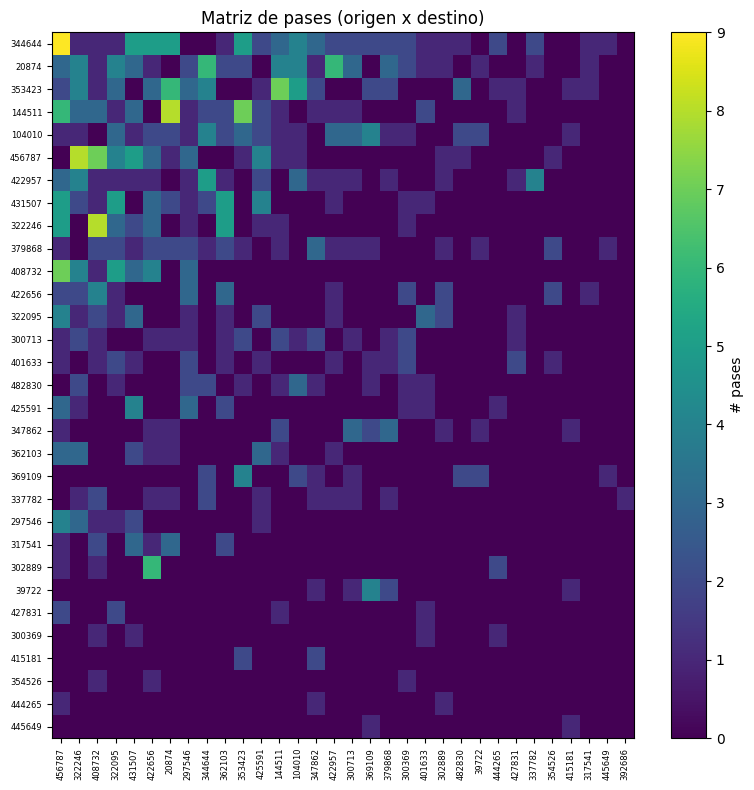

In [7]:
# 4B) “Matriz” de pases (origen x destino) ordenada por strength de salida/entrada
import pandas as pd, numpy as np

# Reconstruye edges_df si falta
if 'edges_df' not in globals():
    edges = [{
        "from_id": u,
        "to_id": v,
        "weight": d.get("weight", 1),
        "success_rate": (d.get("success_count", 0) / max(1, d.get("weight", 1))),
        "dist_avg": (d.get("dist_sum", 0.0) / max(1, d.get("weight", 1))),
    } for u, v, d in G.edges(data=True)]
    edges_df = pd.DataFrame(edges).sort_values("weight", ascending=False)

# Orden de filas/columnas por strength
out_strength = edges_df.groupby("from_id")["weight"].sum().sort_values(ascending=False).index.tolist()
in_strength  = edges_df.groupby("to_id")["weight"].sum().sort_values(ascending=False).index.tolist()

mat = edges_df.pivot_table(index="from_id", columns="to_id", values="weight", fill_value=0)
mat = mat.reindex(index=out_strength, columns=in_strength)

plt.figure(figsize=(8, 8))
plt.imshow(mat.values, aspect="auto")
plt.colorbar(label="# pases")
plt.xticks(ticks=range(len(mat.columns)), labels=[str(c) for c in mat.columns], rotation=90, fontsize=6)
plt.yticks(ticks=range(len(mat.index)), labels=[str(r) for r in mat.index], fontsize=6)
plt.title("Matriz de pases (origen x destino)")
plt.tight_layout()
plt.show()

5) Exportar tablas y snapshots (CSV + figuras)

In [8]:
from pathlib import Path
import pandas as pd

OUT_DIR = ROOT / "data" / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Asegura nodes_df/edges_df
if 'nodes_df' not in globals():
    nodes = [{
        "player_id": n,
        "name": name_map.get(n, str(n)),
        "deg_out": G.out_degree(n),
        "deg_in": G.in_degree(n),
    } for n in G.nodes()]
    nodes_df = pd.DataFrame(nodes)

if 'edges_df' not in globals():
    edges = [{
        "from_id": u, "to_id": v,
        "weight": d.get("weight", 1),
        "success_rate": (d.get("success_count", 0) / max(1, d.get("weight", 1))),
        "dist_avg": (d.get("dist_sum", 0.0) / max(1, d.get("weight", 1))),
    } for u, v, d in G.edges(data=True)]
    edges_df = pd.DataFrame(edges).sort_values("weight", ascending=False)

nodes_csv = OUT_DIR / "nodes_GLOBAL.csv"
edges_csv = OUT_DIR / "edges_GLOBAL.csv"
nodes_df.to_csv(nodes_csv, index=False)
edges_df.to_csv(edges_csv, index=False)
nodes_csv, edges_csv

(WindowsPath('E:/proyectos/MaestriaIAA/tt/FutGNN/data/processed/nodes_GLOBAL.csv'),
 WindowsPath('E:/proyectos/MaestriaIAA/tt/FutGNN/data/processed/edges_GLOBAL.csv'))

6) Reporte por equipo + top duplas de pase

In [9]:
import pandas as pd, numpy as np

# Mapeo equipo si existe
def map_from(df, key, value):
    if key in df and value in df:
        return (df[[key, value]].dropna().drop_duplicates(key).set_index(key)[value].to_dict())
    return {}
team_map = map_from(events, "playerId", "teamId") if 'events' in globals() else {}

# Añade team al nodes_df si falta
if "team" not in nodes_df.columns and team_map:
    nodes_df["team"] = nodes_df["player_id"].map(team_map)

# Métricas por equipo
team_summary = None
if "team" in nodes_df.columns:
    team_summary = nodes_df.groupby("team").agg(
        n_players=("player_id","count"),
        deg_out_sum=("deg_out","sum"),
        deg_in_sum=("deg_in","sum")
    ).reset_index()
    display(team_summary)

# Top 15 duplas por peso y por tasa de éxito (mín 5 intentos)
edges_df["pair"] = list(zip(edges_df["from_id"], edges_df["to_id"]))
top_pairs_by_weight = edges_df.sort_values("weight", ascending=False).head(15)
top_pairs_by_success = (edges_df[edges_df["weight"]>=5]
                        .assign(success_rate_pct=lambda d: 100*d["success_rate"])
                        .sort_values(["success_rate_pct","weight"], ascending=False)
                        .head(15))

print("Top 15 duplas por volumen (peso):")
display(top_pairs_by_weight[["from_id","to_id","weight","success_rate","dist_avg"]])

print("Top 15 duplas por tasa de éxito (>=5 intentos):")
display(top_pairs_by_success[["from_id","to_id","weight","success_rate_pct","dist_avg"]])

,team,n_players,deg_out_sum,deg_in_sum
0,52.0,13,193,119


Top 15 duplas por volumen (peso):


,from_id,to_id,weight,success_rate,dist_avg
152,344644,456787,9,1.000000,21.866857
226,322246,408732,8,1.000000,17.416813
72,144511,20874,8,1.000000,10.656179
10,456787,322246,8,1.000000,10.407834
78,144511,353423,7,0.857143,14.521911
13,456787,408732,7,1.000000,12.977018
276,353423,144511,7,1.000000,17.724224
92,408732,456787,7,1.000000,10.550362
179,20874,344644,6,1.000000,7.914160
278,353423,20874,6,1.000000,10.730040


Top 15 duplas por tasa de éxito (>=5 intentos):


,from_id,to_id,weight,success_rate_pct,dist_avg
152,344644,456787,9,100.0,21.866857
72,144511,20874,8,100.0,10.656179
10,456787,322246,8,100.0,10.407834
226,322246,408732,8,100.0,17.416813
276,353423,144511,7,100.0,17.724224
13,456787,408732,7,100.0,12.977018
92,408732,456787,7,100.0,10.550362
278,353423,20874,6,100.0,10.730040
179,20874,344644,6,100.0,7.914160
186,20874,422957,6,100.0,17.992634
